In [412]:
import pandas as pd
import requests
import bs4
from bs4 import BeautifulSoup
from urllib.parse import urlparse
from collections import deque
from pytrends.request import TrendReq
from datetime import datetime
import time
from collections import defaultdict
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np

In [413]:
df_valid = pd.read_json("valid.json", orient="records")
df_valid["Died"] = pd.to_datetime(df_valid['Died'], unit="ms")
#Get rid of 2018, since its not a complete year
df_valid = df_valid[df_valid["Died"] < datetime.strptime("2018-01-01", "%Y-%m-%d")]

In [631]:
# Function to calculate age at time of death
def calc_age(x):
    return np.floor((x.days)/365)

# Copy data frame and keep relevant columns
df_cod = df_valid.copy()
df_cod = df_cod[["Born","Died","Cause of death"]]
df_cod["Born"] = pd.to_datetime(df_cod["Born"])
# Calculate age at death and save to new column
df_cod["Age at death"] = (df_cod["Died"] - df_cod["Born"]).apply(calc_age)
# Get year of death from date of death and save to new column
df_cod["Death year"] = df_cod["Died"].dt.year

# Create pivot table with mean age at death by year
pv1 = pd.pivot_table(df_cod, values="Age at death", index="Death year")
pv1

,Age at death
Death year,
2004,75.125000
2005,77.500000
2006,79.660714
2007,78.937500
2008,78.241379
2009,78.955556
2010,75.419355
2011,74.098361
2012,80.206897


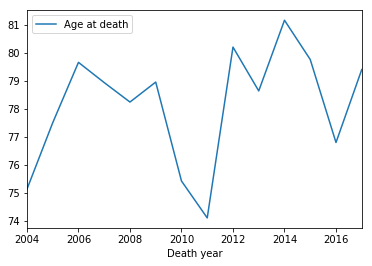

In [586]:
# Visualizing mean age at death by year
df1 = pd.DataFrame(pv1.to_records())
df1 = df1.set_index("Death year")
df1.plot()
plt.show()

In [587]:
# Copy data frame and drop rows containing null values
df_cod2 = df_cod.copy()
df_cod2 = df_cod2.dropna()

In [588]:
# Function to clean up cause of death data/aggregate similar causes
def standardize_cod(cod_in):
    cod_in = cod_in.lower()
    cod_in = cod_in.strip()
    
    cod_in = cod_in.replace("[1]", "")
    cod_in = cod_in.replace("]", "")
    cod_in = cod_in.replace("ailment", "disease")
    
    if "suicide" in cod_in:
        cod_in = "suicide"
    if "murder" in cod_in or "assassin" in cod_in:
        cod_in = "murder"
    if "accident" in cod_in or "collision" in cod_in or "fall" in cod_in or "struck" in cod_in:
        cod_in = "accident"
    if "drug" in cod_in or "alcohol" in cod_in:
        cod_in = "substance abuse"
    if "surgery" in cod_in or "ectomy" in cod_in:
        cod_in = "complications from surgery"
    if "unknown" in cod_in:
        cod_in = "unknown"
        
    if "cancer" in cod_in or "leukemia" in cod_in or "leukaemia" in cod_in or "oma" in cod_in or "polycythemia vera" in cod_in or "myelodysplastic syndrome" in cod_in:
        cod_in = "cancer"
    if "pneumonia" in cod_in:
        cod_in = "pneumonia"
    if "stroke" in cod_in:
        cod_in = "stroke"
    if "heart attack" in cod_in:
        cod_in = "heart attack"
    if "failure" in cod_in or "insufficiency" in cod_in:
        cod_in = "organ failure"
    if "alzheimer" in cod_in:
        cod_in = "alzheimer's"
    if "aneurysm" in cod_in:
        cod_in = "aneurysm"
    if "diabetes" in cod_in:
        cod_in = "diabetes"
    if "dementia" in cod_in:
        cod_in = "dementia"
    if "sepsis" in cod_in or "septic" in cod_in:
        cod_in = "sepsis"
    if "vascul" in cod_in:
        cod_in = "vascular disease"
    if "heart disease" in cod_in or "pulmonary disease" in cod_in or "cardiovascular disease" in cod_in:
        cod_in = "heart disease"
    if "pulmonary edema" in cod_in or "pulmonary fibrosis" in cod_in or "emphysema" in cod_in or "chest infection" in cod_in:
        cod_in = "lung disease"
    if "neuron" in cod_in or "amyotrophic lateral sclerosis" in cod_in or "neuron" in cod_in:
        cod_in = "nervous system disease"
    if "asphyxiation" in cod_in or "strangulation" in cod_in:
        cod_in = "asphyxiation"
    if "embolism" in cod_in or "clot" in cod_in:
        cod_in = "embolism"
    if "hemorrhage" in cod_in or "haemorrhage" in cod_in:
        cod_in = "hemorrhage"
    
    cod_in = cod_in.lower()
    cod_in = cod_in.strip()
    
    return cod_in

In [632]:
# Apply standardizing function to "Cause of death" column
df_cod2["Cause of death"] = df_cod2["Cause of death"].apply(standardize_cod)
df_cod2["Cause of death"].value_counts()

cancer                        76
organ failure                 28
heart attack                  23
pneumonia                     18
stroke                        11
suicide                        8
alzheimer's                    7
lung disease                   7
heart disease                  6
accident                       6
cardiac arrest                 4
substance abuse                4
vascular disease               4
diabetes                       3
embolism                       3
sepsis                         3
hemorrhage                     2
asphyxiation                   2
murder                         2
complications from surgery     2
aneurysm                       2
nervous system disease         2
dementia                       2
gunshot wounds                 1
cerebral hypoxia               1
polymyalgia rheumatica         1
kidney disease                 1
sudden death                   1
dengue fever                   1
unknown                        1
Name: Caus

In [628]:
# Group data by death year and cause of death
grouped = df_cod2.groupby(["Death year", "Cause of death"])
grouped.size()

Death year  Cause of death            
2004        cancer                        3
            heart attack                  1
            heart disease                 1
            murder                        1
            organ failure                 2
            pneumonia                     2
            sepsis                        1
            stroke                        2
            vascular disease              1
2005        asphyxiation                  1
            cancer                        3
            complications from surgery    1
            heart attack                  1
            lung disease                  3
            organ failure                 3
            substance abuse               1
2006        cancer                        4
            heart attack                  1
            organ failure                 2
            pneumonia                     2
            stroke                        2
2007        accident                 

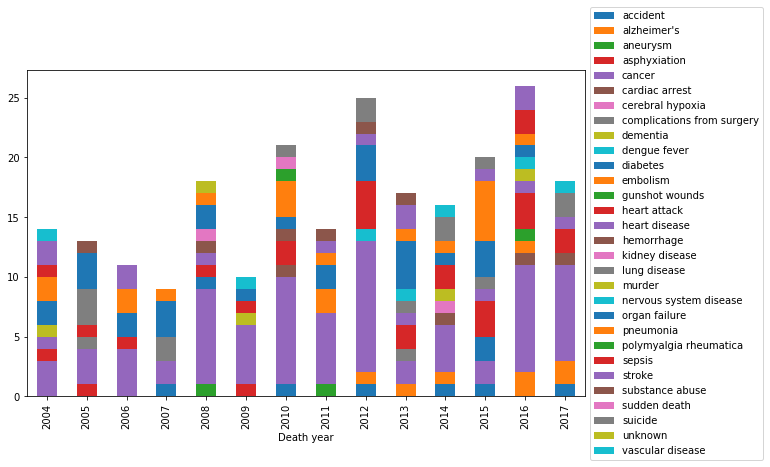

In [634]:
# Visualizing causes of death by year
# This is hard to read because there are so many different causes of death, but left here for reference
grouped.size().unstack().fillna(0).plot(kind="bar", stacked=True, figsize=(10,6)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [635]:
# Function further simplifying cause of death
# Following definition of "unnatural death" as seen on wiki page: https://en.wikipedia.org/wiki/Unnatural_death
def classify_natural(cod_in):
    if cod_in == "unknown" or cod_in == "sudden death":
        return "unknown"
    elif cod_in in ["accident", "asphyxiation", "complications from surgery", "gunshot wounds", "murder", "substance abuse", "suicide"]:
        return "unnatural death"
    else:
        return "natural death"

In [637]:
# Copy data frame and apply function
df_cod3 = df_cod2.copy()
df_cod3["Cause of death"] = df_cod3["Cause of death"].apply(classify_natural)
df_cod3

,Born,Died,Cause of death,Age at death,Death year
0,1974-07-25,2011-05-10,natural death,36.0,2011
2,1947-05-14,2006-10-02,natural death,59.0,2006
4,1963-08-09,2012-02-11,unnatural death,48.0,2012
8,1972-01-13,2017-05-09,natural death,45.0,2017
9,1941-06-22,2006-11-09,natural death,65.0,2006
11,1936-09-27,2012-02-01,unnatural death,75.0,2012
13,1955-09-29,2016-11-14,natural death,61.0,2016
28,1922-05-13,2009-04-25,natural death,87.0,2009
30,1945-11-27,2013-12-31,unnatural death,68.0,2013
34,1915-12-22,2010-10-16,natural death,94.0,2010


In [638]:
# Group data by death year and cause of death
grouped2 = df_cod3.groupby(["Death year", "Cause of death"])
grouped2.size()

Death year  Cause of death 
2004        natural death      13
            unnatural death     1
2005        natural death      10
            unnatural death     3
2006        natural death      11
2007        natural death       8
            unnatural death     1
2008        natural death      17
            unknown             1
2009        natural death       9
            unnatural death     1
2010        natural death      18
            unknown             1
            unnatural death     2
2011        natural death      13
            unnatural death     1
2012        natural death      21
            unnatural death     4
2013        natural death      15
            unnatural death     2
2014        natural death      13
            unnatural death     3
2015        natural death      18
            unnatural death     2
2016        natural death      24
            unnatural death     2
2017        natural death      15
            unnatural death     3
dtype: int64

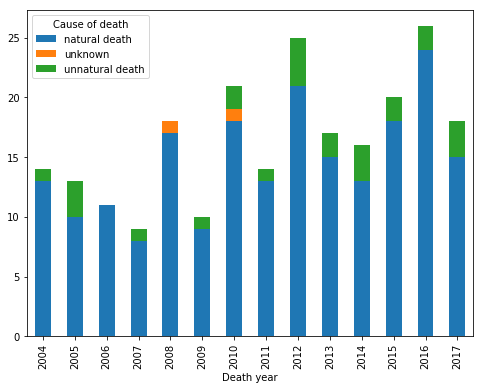

In [639]:
# Plot causes of death by year
grouped2.size().unstack().plot(kind="bar", stacked=True, figsize=(8,6))
plt.show()

In [594]:
# Out of curiosity, taking a look at mean death age for data frame that has null values removed
pv2 = pd.pivot_table(df_cod3, values="Age at death", index="Death year")
pv2

,Age at death
Death year,
2004,76.285714
2005,78.384615
2006,74.545455
2007,79.666667
2008,76.944444
2009,78.000000
2010,73.904762
2011,69.857143
2012,76.240000


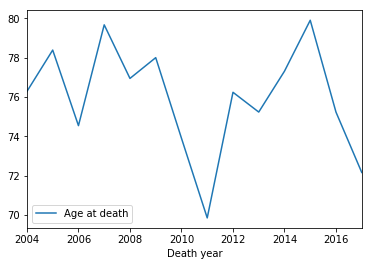

In [595]:
# Plot mean death age by year
df2 = pd.DataFrame(pv2.to_records())
df2 = df2.set_index("Death year")
df2.plot()
plt.show()